<a href="https://colab.research.google.com/github/hwarang97/Image_classification/blob/main/VGG16_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torch.nn.modules.activation import Softmax
import torch
from torch import nn 
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor() # 이미지, 배열을 텐서로 변경하고, 픽셀값을 정규하시켜줌
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor() 
)

train_dataloader = DataLoader(training_data, batch_size=128)
test_dataloader = DataLoader(test_data, batch_size=128)

class VGG(nn.Module):
  def __init__(self):
    super(self).__init__()
    self.flatten = nn.Flatten()
    self.conv_relue_stack = nn.Sequential(
        nn.Conv2d(1, 6, 3, padding=1), # input 1*28*28, zero_padding=1, output 6*28*28, same padding
        nn.ReLU,
        nn.MaxPool2d(2), # 6*1*14*14
        nn.Conv2d(6, 16, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2), # 16*1*7*7
    )

    self.linear_relu_stack = nn.Sequential(
      nn.Linear(16*7*7, 84),
      nn.ReLU(),
      nn.Linear(84, 10)
    )

  def forward(self, x):
    x1 = self.conv_relu_stack(x)
    x2 = self.flatten(x1)
    logits = self.linear_relu_stack(x2)
    return logits

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



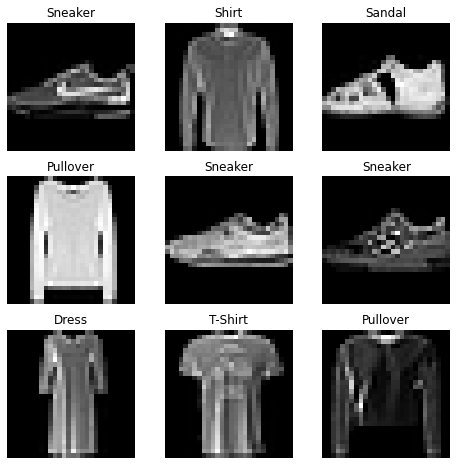

In [5]:
import matplotlib.pyplot as plt

# 데이터셋이 제대로 들어갔는지 시각화해서 확인

labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, rows*cols+1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item() # Tensor에서 값이 하나만 있는 걸 꺼낼때 사용
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off') # 축 눈금등을 없애주는 메소드, 기본값:True
  plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [9]:
# 데이터 갯수 확인
len(training_data), len(test_data)

(60000, 10000)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader, 1):

    X = X.to(device)
    y = y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 1000 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')

In [ ]:
model = Lenet_5().to(device)
print(model)

Lenet_5(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_sigmoid_stack): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=400, out_features=84, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [ ]:
learning_rate = 1e-3
batch_size = 1
epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
  print(f'Epoch {t+1}\n-----------------------------------')
  train_loop(train_dataloader, model, loss_fn, optimizer)
  test_loop(test_dataloader, model, loss_fn)
print('Done!!!')

Epoch 1
-----------------------------------
loss: 2.307811 [ 1000/60000]
loss: 2.344677 [ 2000/60000]
loss: 2.376512 [ 3000/60000]
loss: 2.238244 [ 4000/60000]
loss: 2.430893 [ 5000/60000]
loss: 2.229689 [ 6000/60000]
loss: 2.387041 [ 7000/60000]
loss: 2.503430 [ 8000/60000]
loss: 2.490960 [ 9000/60000]
loss: 2.237942 [10000/60000]
loss: 2.377086 [11000/60000]
loss: 2.415211 [12000/60000]
loss: 2.314795 [13000/60000]
loss: 2.353487 [14000/60000]
loss: 2.248267 [15000/60000]
loss: 2.130532 [16000/60000]
loss: 2.297227 [17000/60000]
loss: 2.313713 [18000/60000]
loss: 2.294303 [19000/60000]
loss: 2.421269 [20000/60000]
loss: 2.368023 [21000/60000]
loss: 2.212766 [22000/60000]
loss: 2.338611 [23000/60000]
loss: 2.372835 [24000/60000]
loss: 2.278524 [25000/60000]
loss: 2.383859 [26000/60000]
loss: 2.431303 [27000/60000]
loss: 2.371299 [28000/60000]
loss: 2.294688 [29000/60000]
loss: 2.245003 [30000/60000]
loss: 2.361755 [31000/60000]
loss: 2.390866 [32000/60000]
loss: 2.296299 [33000/60000]